In [1]:
import json
import re
import os

import random
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels


Using TensorFlow backend.


In [71]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})

# Convert data

In [2]:
trainrecipts = json.load(open('recipies.json','r'))

# Quick&dirty code to extract info2list
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())      

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())


In [3]:
## merge all the ingredients into sentences to generate WordtoVec model
sentences = list()
# one hot ingredients


for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize = (25,25))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Build LSTM model for classification

## Prepare data

In [5]:
X = sentences
max_length = max([len(s) for s in X])
# maximum length of a number of ingredients

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)

X_token = tokenizer_obj.texts_to_sequences(X)
X_pad = pad_sequences(X_token, maxlen = max_length, padding = 'post')

In [6]:
y = raw_cuisines
np.shape(y)
le = LabelEncoder()
le.fit(y)

y_cat = le.transform(y) # convert y (cuisine to categorical data)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.33, random_state=42)

In [8]:
EMBEDDING_DIM = 300
n_cuisines = 20

## Model development

### 1. Load the word2vec embedding that we produced earlier and use it as our embedding layer

In [21]:
embeddings_index = {}
f = open(os.path.join('','ingredients_embedding.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()

word_index = tokenizer_obj.word_index
num_words = len(word_index) + 1

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[-EMBEDDING_DIM:]    

#### GRU

The GRU is like a long short-term memory (LSTM) with forget gate. but has fewer parameters than LSTM, as it lacks an output gate.GRU's performance on certain tasks of polyphonic music modeling and speech signal modeling was found to be similar to that of LSTM. GRUs have been shown to exhibit even better performance on certain smaller datasets.

In [24]:
model_wv_seq = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq.add(embedding_layer)
# model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model_wv_seq.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2))
model_wv_seq.add(Dense(n_cuisines, activation = 'softmax'))
model_wv_seq.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_wv_seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 300)           1961400   
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
Total params: 1,994,028
Trainable params: 32,628
Non-trainable params: 1,961,400
_________________________________________________________________


In [25]:
model_wv_seq.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 28s 1ms/step - loss: 2.6882 - acc: 0.1956 - val_loss: 2.6060 - val_acc: 0.1966
Epoch 2/5
26648/26648 [==============================] - 26s 971us/step - loss: 2.5493 - acc: 0.2402 - val_loss: 2.4301 - val_acc: 0.2804
Epoch 3/5
26648/26648 [==============================] - 26s 973us/step - loss: 2.3614 - acc: 0.2962 - val_loss: 2.2592 - val_acc: 0.3257
Epoch 4/5
26648/26648 [==============================] - 26s 974us/step - loss: 2.2330 - acc: 0.3445 - val_loss: 2.1421 - val_acc: 0.3783
Epoch 5/5
26648/26648 [==============================] - 26s 976us/step - loss: 2.1496 - acc: 0.3716 - val_loss: 2.0733 - val_acc: 0.3961


#### Bidirectional GRU

The accuracy is not high. This may due to the order in the ingredients. In theory, one ingredient appears before or after anothger shouldn't affect the cuisine. However, in the one directional GRU, the order will affect the results. Therefore, I use bidirectional network instead.

In [26]:
model_wv_seq_bi = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq_bi.add(embedding_layer)
# model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model_wv_seq_bi.add(Bidirectional(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model_wv_seq_bi.add(Dense(n_cuisines, activation = 'softmax'))
model_wv_seq_bi.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_wv_seq_bi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 300)           1961400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 2,026,636
Trainable params: 65,236
Non-trainable params: 1,961,400
_________________________________________________________________


In [27]:
model_wv_seq_bi.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 51s 2ms/step - loss: 2.5306 - acc: 0.2568 - val_loss: 2.2493 - val_acc: 0.3506
Epoch 2/5
26648/26648 [==============================] - 49s 2ms/step - loss: 2.2104 - acc: 0.3575 - val_loss: 2.1206 - val_acc: 0.3789
Epoch 3/5
26648/26648 [==============================] - 49s 2ms/step - loss: 2.1255 - acc: 0.3812 - val_loss: 2.0479 - val_acc: 0.3965
Epoch 4/5
26648/26648 [==============================] - 49s 2ms/step - loss: 2.0654 - acc: 0.3953 - val_loss: 1.9988 - val_acc: 0.4092
Epoch 5/5
26648/26648 [==============================] - 49s 2ms/step - loss: 2.0177 - acc: 0.4090 - val_loss: 1.9576 - val_acc: 0.4242


#### Accuracy improved from one directional GRU to bidirectional GRU
#### Next is to try bidirectional LSTM 

In [28]:
model_wv_seq_bi_LSTM = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq_bi_LSTM.add(embedding_layer)
# model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model_wv_seq_bi_LSTM.add(Bidirectional(LSTM(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model_wv_seq_bi_LSTM.add(Dense(n_cuisines, activation = 'softmax'))
model_wv_seq_bi_LSTM.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_wv_seq_bi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 300)           1961400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 2,026,636
Trainable params: 65,236
Non-trainable params: 1,961,400
_________________________________________________________________


In [29]:
model_wv_seq_bi_LSTM.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 62s 2ms/step - loss: 2.5472 - acc: 0.2480 - val_loss: 2.2682 - val_acc: 0.3367
Epoch 2/5
26648/26648 [==============================] - 59s 2ms/step - loss: 2.2269 - acc: 0.3532 - val_loss: 2.1257 - val_acc: 0.3752
Epoch 3/5
26648/26648 [==============================] - 59s 2ms/step - loss: 2.1301 - acc: 0.3767 - val_loss: 2.0669 - val_acc: 0.3898
Epoch 4/5
26648/26648 [==============================] - 59s 2ms/step - loss: 2.0775 - acc: 0.3861 - val_loss: 2.0202 - val_acc: 0.4032
Epoch 5/5
26648/26648 [==============================] - 59s 2ms/step - loss: 2.0336 - acc: 0.4003 - val_loss: 1.9716 - val_acc: 0.4151


#### Accuracy didn't change by using  LSTM, therefore, go back to using GRU

### 2. train the embedding layer from scratch instead of using word2vec

In [34]:
vocab_size = 6714 #number of ingredients, got from EDA

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model.add(Bidirectional(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model.add(Dense(n_cuisines, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 65, 300)           2014200   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
Total params: 2,079,436
Trainable params: 2,079,436
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Train on 26648 samples, validate on 13126 samples
Epoch 1/5
26648/26648 [==============================] - 57s 2ms/step - loss: 1.9562 - acc: 0.4390 - val_loss: 1.3777 - val_acc: 0.5958
Epoch 2/5
26648/26648 [==============================] - 53s 2ms/step - loss: 1.1986 - acc: 0.6457 - val_loss: 1.0608 - val_acc: 0.6884
Epoch 3/5
26648/26648 [==============================] - 53s 2ms/step - loss: 0.9274 - acc: 0.7235 - val_loss: 0.9606 - val_acc: 0.7151
Epoch 4/5
26648/26648 [==============================] - 53s 2ms/step - loss: 0.7671 - acc: 0.7747 - val_loss: 0.9117 - val_acc: 0.7339
Epoch 5/5
26648/26648 [==============================] - 53s 2ms/step - loss: 0.6630 - acc: 0.8078 - val_loss: 0.8968 - val_acc: 0.7416


In [36]:
from keras.optimizers import Adam

adam = Adam(lr=0.0001) # reduce training rate

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = 128, epochs = 50, \
                    validation_data = (X_test, y_test),
                    callbacks=[es, mc])
# note that the model has trained for 5 epoches previously

Train on 26648 samples, validate on 13126 samples
Epoch 1/50
26648/26648 [==============================] - 58s 2ms/step - loss: 0.5612 - acc: 0.8411 - val_loss: 0.8927 - val_acc: 0.7428
Epoch 2/50
26648/26648 [==============================] - 54s 2ms/step - loss: 0.5523 - acc: 0.8449 - val_loss: 0.8926 - val_acc: 0.7437
Epoch 3/50
26648/26648 [==============================] - 53s 2ms/step - loss: 0.5420 - acc: 0.8473 - val_loss: 0.8929 - val_acc: 0.7437
Epoch 4/50
26648/26648 [==============================] - 53s 2ms/step - loss: 0.5318 - acc: 0.8502 - val_loss: 0.8939 - val_acc: 0.7448
Epoch 5/50
26648/26648 [==============================] - 53s 2ms/step - loss: 0.5229 - acc: 0.8529 - val_loss: 0.8952 - val_acc: 0.7456
Epoch 6/50
26648/26648 [==============================] - 53s 2ms/step - loss: 0.5158 - acc: 0.8531 - val_loss: 0.8963 - val_acc: 0.7455
Epoch 7/50
26648/26648 [==============================] - 53s 2ms/step - loss: 0.5080 - acc: 0.8565 - val_loss: 0.8983 - val_acc

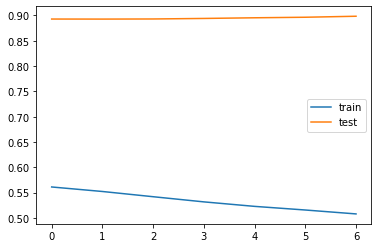

In [38]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

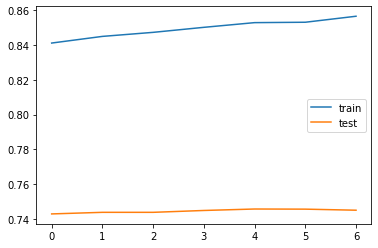

In [39]:
# plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Large difference between train and test, maybe the model is prone to overfitting. Try to increase the number of dropout

In [79]:
vocab_size = 6714 #number of ingredients, got from EDA

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model.add(Bidirectional(GRU(units = 32, dropout = 0.4, recurrent_dropout = 0.4)))
model.add(Dense(n_cuisines, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 300)           2014200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 2,079,436
Trainable params: 2,079,436
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = 128, epochs = 50, \
                    validation_data = (X_test, y_test),
                    callbacks=[es, mc])
# note that the model has trained for 5 epoches previously

Train on 26648 samples, validate on 13126 samples
Epoch 1/50
26648/26648 [==============================] - 57s 2ms/step - loss: 0.6407 - acc: 0.8134 - val_loss: 0.8951 - val_acc: 0.7404
Epoch 2/50
26648/26648 [==============================] - 52s 2ms/step - loss: 0.6119 - acc: 0.8247 - val_loss: 0.8926 - val_acc: 0.7409
Epoch 3/50
26648/26648 [==============================] - 52s 2ms/step - loss: 0.5989 - acc: 0.8285 - val_loss: 0.8911 - val_acc: 0.7422
Epoch 4/50
26648/26648 [==============================] - 52s 2ms/step - loss: 0.5903 - acc: 0.8308 - val_loss: 0.8909 - val_acc: 0.7423
Epoch 5/50
26648/26648 [==============================] - 52s 2ms/step - loss: 0.5797 - acc: 0.8351 - val_loss: 0.8908 - val_acc: 0.7430
Epoch 6/50
26648/26648 [==============================] - 52s 2ms/step - loss: 0.5721 - acc: 0.8362 - val_loss: 0.8905 - val_acc: 0.7431
Epoch 7/50
26648/26648 [==============================] - 52s 2ms/step - loss: 0.5651 - acc: 0.8361 - val_loss: 0.8920 - val_acc

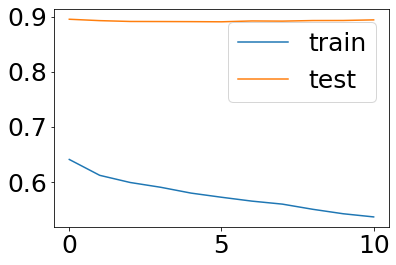

In [57]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

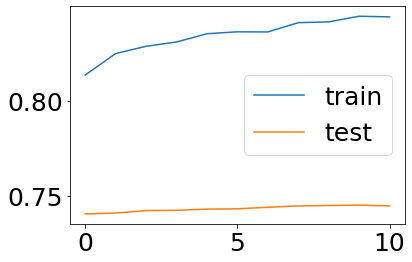

In [56]:
# plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [44]:
model.load_weights('best_model.hdf5')

In [45]:
def predict_model_index(i, le, y_test, model):
    results = model.predict(np.expand_dims(X_test[i],axis = 0))
    results = np.argmax(results)
    results = le.inverse_transform([results])
    print('predict cusine is', results, 'while real cusine is',le.inverse_transform([y_test[i]]))

In [46]:
for i in range (10):
    predict_model_index(i, le, y_test, model)

predict cusine is ['chinese'] while real cusine is ['chinese']
predict cusine is ['southern_us'] while real cusine is ['spanish']
predict cusine is ['greek'] while real cusine is ['greek']
predict cusine is ['indian'] while real cusine is ['indian']
predict cusine is ['italian'] while real cusine is ['italian']
predict cusine is ['mexican'] while real cusine is ['mexican']
predict cusine is ['italian'] while real cusine is ['italian']
predict cusine is ['cajun_creole'] while real cusine is ['cajun_creole']
predict cusine is ['greek'] while real cusine is ['greek']
predict cusine is ['mexican'] while real cusine is ['mexican']


In [47]:
y_pred = model.predict(X_test, verbose = 1)
y_pred_max = np.argmax(y_pred,axis = 1)

13126/13126 [==============================] - 33s 3ms/step


In [75]:
labels = le.classes_ # get label names for the confusion matrix
# Plot normalized confusion matrix

In [78]:
plot_confusion_matrix(y_test, y_pred_max, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion_nn1.jpg')

### Bad performance class: brazilian, british, filipino, irish, jamaican, russian, spanish, vietnamese are also minority classes, should do data augumentation

## Data augmentation for the minority class

choose the minority classes above that doesn't perform well:

In [9]:
choosen_classes = ["brazilian", "british", "filipino", "irish", "jamaican", "russian", "spanish", "vietnamese"]

funciton to shuffle the position of the ingredients within the recipes

In [10]:
def shuffle_whole_class(tokens_class, n):
    shuffled =[]
    
    for i in range(len(tokens_class)):
        for j in range(n):
            new_tokens = random.sample(tokens_class[i], len(tokens_class[i]))
            shuffled.append(new_tokens)
    
    return(shuffled)

prepare data to train and test set

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_token, raw_cuisines, test_size=0.33, random_state=42)
# create training and test class

X_test = pad_sequences(X_test, maxlen = max_length, padding = 'post')
# pad to fixed length of 65 for each example
y_test = le.transform(y_test)
# convert y (cuisine) to one hot vector

new_x = np.asarray(X_train)
new_y = np.asarray(y_train)

In [31]:
np.shape(new_x)

(26648,)

In [32]:
np.shape(new_y)

(26648,)

In [33]:
X_train = pad_sequences(X_train, maxlen = max_length, padding = 'post')

In [34]:
np.shape(X_train)

(26648, 65)

function to create new dataset after shuffling the ingredients

In [60]:
def create_new_data(new_y, new_x, choosen_classes, X_train, y_train):
    for i, item in enumerate(choosen_classes):
        if i == 0: 
            new_trainX = X_train
            new_trainy = np.asarray(y_train)
        else:
            chosen_index = np.where(new_y == item)
            chosen_x = new_x[chosen_index]
            print (item,'has',np.shape(chosen_x)[0],'examples')
            extend_x = shuffle_whole_class(chosen_x, 10)
            extend_x = pad_sequences(extend_x, maxlen = max_length, padding = 'post')
            print (item,'has',np.shape(extend_x)[0], 'examples now')

            new_trainX = np.vstack((new_trainX, extend_x)) # add the new data to the training set

            extend_y = np.asarray([item]*len(extend_x))
            print('extend_y',np.shape(extend_y))
            new_trainy = np.hstack((new_trainy, extend_y)) # add the new data to the training set

            print(np.shape(new_trainX))
            print(np.shape(new_trainy))
    return(new_trainX, new_trainy)
        

In [61]:
new_trainX, new_trainy = create_new_data(new_y, new_x, choosen_classes, X_train, y_train)

british has 533 examples
british has 5330 examples now
extend_y (5330,)
(31978, 65)
(31978,)
filipino has 530 examples
filipino has 5300 examples now
extend_y (5300,)
(37278, 65)
(37278,)
irish has 445 examples
irish has 4450 examples now
extend_y (4450,)
(41728, 65)
(41728,)
jamaican has 376 examples
jamaican has 3760 examples now
extend_y (3760,)
(45488, 65)
(45488,)
russian has 334 examples
russian has 3340 examples now
extend_y (3340,)
(48828, 65)
(48828,)
spanish has 669 examples
spanish has 6690 examples now
extend_y (6690,)
(55518, 65)
(55518,)
vietnamese has 557 examples
vietnamese has 5570 examples now
extend_y (5570,)
(61088, 65)
(61088,)


In [62]:
np.shape(new_trainX)

(61088, 65)

In [63]:
np.shape(new_trainy)

(61088,)

In [64]:
new_trainy

array(['chinese', 'italian', 'mexican', ..., 'vietnamese', 'vietnamese',
       'vietnamese'], dtype='<U12')

shuffle again all the exmaples as when the new dataset was added to the original training, data will the same class were one next another

In [65]:
new_trainX, new_trainy = shuffle(new_trainX, new_trainy, random_state=0)
# shuffle the training examples

In [66]:
new_trainy

array(['vietnamese', 'jamaican', 'british', ..., 'jamaican', 'jamaican',
       'southern_us'], dtype='<U12')

convert to array

In [67]:
new_trainX = np.asarray(new_trainX)
new_trainy = np.asarray(new_trainy)
new_trainy = le.transform(new_trainy) # convert y (cuisine to categorical data)

define model

In [69]:
n_cuisines = 20
EMBEDDING_DIM = 300
vocab_size = 6714

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model.add(Bidirectional(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
model.add(Dense(n_cuisines, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True)

W0722 18:02:49.955086 139849618265856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 18:02:49.971321 139849618265856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 18:02:49.974601 139849618265856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 18:02:50.152424 139849618265856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The n

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 65, 300)           2014200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
Total params: 2,079,436
Trainable params: 2,079,436
Non-trainable params: 0
_________________________________________________________________


train model with early stopping

In [70]:
history = model.fit(new_trainX, new_trainy, batch_size = 128, epochs = 50, \
                    validation_data = (X_test, y_test),
                    callbacks=[es, mc])

W0722 18:02:53.409235 139849618265856 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 61088 samples, validate on 13126 samples
Epoch 1/50
61088/61088 [==============================] - 106s 2ms/step - loss: 1.5174 - acc: 0.5528 - val_loss: 1.3502 - val_acc: 0.5630
Epoch 2/50
61088/61088 [==============================] - 102s 2ms/step - loss: 0.6627 - acc: 0.8125 - val_loss: 1.1132 - val_acc: 0.6647
Epoch 3/50
61088/61088 [==============================] - 102s 2ms/step - loss: 0.4705 - acc: 0.8663 - val_loss: 1.0512 - val_acc: 0.6940
Epoch 4/50
61088/61088 [==============================] - 101s 2ms/step - loss: 0.3759 - acc: 0.8954 - val_loss: 1.0720 - val_acc: 0.7023
Epoch 5/50
61088/61088 [==============================] - 101s 2ms/step - loss: 0.3215 - acc: 0.9094 - val_loss: 1.0828 - val_acc: 0.7069
Epoch 6/50
61088/61088 [==============================] - 101s 2ms/step - loss: 0.2792 - acc: 0.9223 - val_loss: 1.1151 - val_acc: 0.7103
Epoch 7/50
61088/61088 [==============================] - 101s 2ms/step - loss: 0.2518 - acc: 0.9286 - val_loss: 1.1417 - 

In [72]:
y_pred = model.predict(X_test, verbose = 1)
y_pred_max = np.argmax(y_pred,axis = 1)

13126/13126 [==============================] - 30s 2ms/step


Normalized confusion matrix


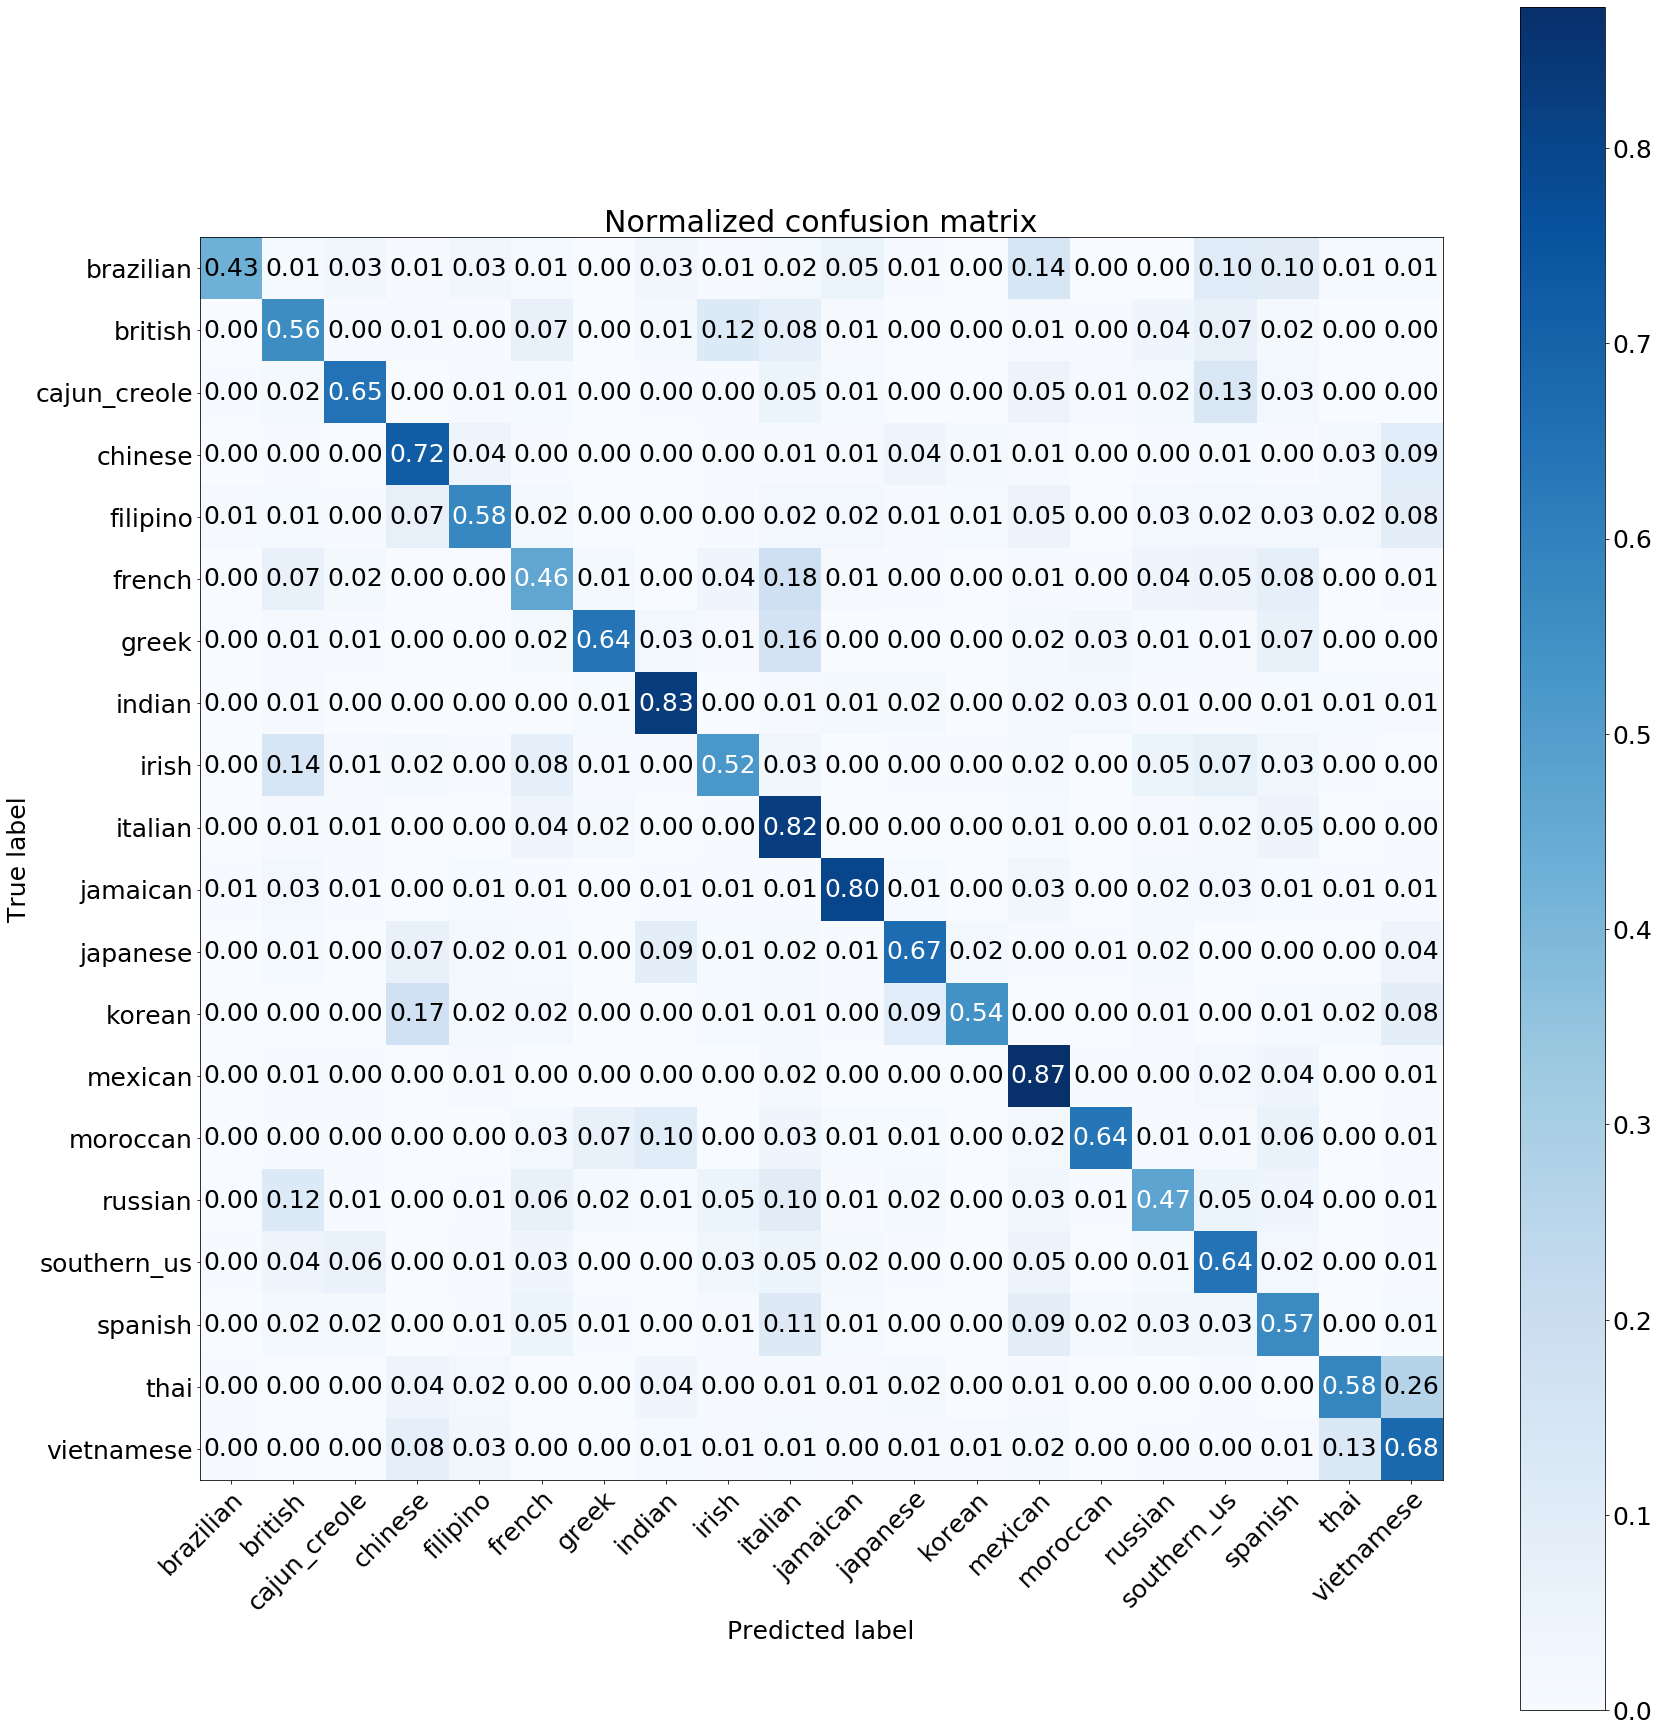

<Figure size 432x288 with 0 Axes>

In [77]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_max, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig('final_confusion.png')